# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem (NEP) **PINN**

### Importing library

In [1]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 9.7 MB/s eta 0:00:00:00:01:01m

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import sys
sys.path.append('../../CppToPython')

import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import pandas as pd

### Initialize

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

np.random.seed(23)

# PART 1 - Problem definition
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu) \text{  (NEP1)}
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

The forcing term, that does not depend on the parameters, defined as
$$
g(x;\mu) = g_1 = 100 \sin(2\pi x_0) \cos(2\pi x_1) \quad \forall x = (x_0, x_1) \in \Omega.
$$

**Tasks:**

1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model -> using high fidelity element approximation of POD
2. Solve the problem with a parametric PINN -> find the NN structure to reduce the problem
3. Compare the two approaches in terms of computational costs and accuracy with respect to the full order model -> compare in terms of execution time & error
4. **Optional:** Solve the problem with the POD-NN approach and compare it to the other two strategies.

In [4]:
# Points for the diffusion term
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F') # Fortran order of memorization of the matrix: column by column
	return values_a.ctypes.data

# Points for the reaction term
def Elliptic_c(numPoints, points):
	values_c = np.ones(numPoints, order='F') 
	return values_c.ctypes.data    

# Non linear reaction term
# numPoints := quadrature points
def Elliptic_non_linear_c(numPoints, points, u, u_x, u_y):
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in the quadrature points numPoints
	values_nl_c = vec_u
	return values_nl_c.ctypes.data

def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
    # Converts u_x and u_y pointers or arrays to NumPy arrays
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
	values_nl_d_f = np.zeros((2, numPoints), order='F')

    # Inserts the partial derivatives of u into the new array values_nl_d_f
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
    
	return values_nl_d_f.ctypes.data

# Nonlinear reaction term
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
    vec_u = gedim.make_nd_array(u, numPoints, np.double)
    vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
    vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
    values_nl_f = (mu_0/mu_1) * (np.exp(mu_1*vec_u)-1) # Computation of f
    
    return values_nl_f.ctypes.data

def Elliptic_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

    # Definition of u
	values_ex = mu_0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
    
	return values_ex.ctypes.data

def Elliptic_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0: # wrt x
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) # 16⋅(1−2x)⋅y⋅(1−y)
	elif direction == 1: # wrt y
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]) # 16⋅(1−2y)⋅x⋅(1−x)
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

# Forcing term for evaluating the error
def Elliptic_exactSolution_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    
    # Definition of u
    # values_ex = 2*mu_0*(y*(1-y)+x*(1-x)) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*x*y*(1-x)(1-y)) -1)
    values_ex = 2*mu_0*(matPoints[1,:]*(1-matPoints[1,:])+matPoints[0,:]*(1-matPoints[0,:])) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*matPoints[0,:]*matPoints[1,:]*(1-matPoints[0,:])*(1-matPoints[1,:])) -1)
    
    return values_ex.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

# Definition of the forcing term g_1
def Elliptic_g_1(numPoints, points): 
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double) # X
    # g_1(X,mu) = 100*sin(2pi*x)*cos(2pi*y), X=(x,y)
    values_g = 100*np.sin(2*np.pi*matPoints[0,:])*np.cos(2*np.pi*matPoints[1,:])
    return values_g.ctypes.data

#### Mesh and domain definition

In [5]:
order = 1 # Start from 1, at the END we will decide if we have to improve the order
P = [0.1, 1.] # Parametric space

In [6]:
# Fix the right domain
mesh_size = 0.00312

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

In [7]:
# Initialization of the guess of the solution --> the NM converges rapidly if we start not far away from the solution
u_k = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong = np.zeros(problemData['NumberStrongs'], order='F') # Vector containing the strongly imposed components of the solution, ie Dirichlet conditions

#### Newton method for high fidelity snapshots computation - TO COMPUTE THE ERROR

In [8]:
# RELATIVO A G_1

sample_mu_0 = np.random.uniform(0.1, 1, 300)  # Uniform sampling in mu_Range
sample_mu_1 = np.random.uniform(0.1, 1, 300)

snapshots_matrix = []
convergence_history = []
max_iterations = 100
newton_tol = 1e-8

sol_quad_hf = []        # u evaluated on quadrature points
der_x_quad_hf = []      # du/dx evaluated on quadrature points
der_y_quad_hf = []      # du/dy evaluated on quadrature points

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    rel_error = 0

    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side
        stiffness, stiffnessStrong = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
        reaction, reactionStrong = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)

        # 2- Right side
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)

        # Solve
        du = gedim.LUSolver(
            stiffness + reaction,
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v,
            lib
        )

        # Update
        u_k = u_k + du

        # Norms
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        du_norms_for_sample.append(du_norm)
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)

        rel_error = du_norm / u_k_norm       
        num_iteration += 1

    snapshots_matrix.append(np.copy(u_k))
    convergence_history.append(du_norms_for_sample)

    # Evaluate solution and derivatives at quadrature points
    (
        numQuadraturePoints,
        quadraturePoints,
        quadratureWeights,
        solution_hf,
        solution_x_hf,
        solution_y_hf
    ) = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)

    sol_quad_hf.append(solution_hf)
    der_x_quad_hf.append(solution_x_hf)
    der_y_quad_hf.append(solution_y_hf)

# Convert to arrays
snapshots_matrix = np.array(snapshots_matrix)
sol_quad_hf = np.array(sol_quad_hf)
der_x_quad_hf = np.array(der_x_quad_hf)
der_y_quad_hf = np.array(der_y_quad_hf)

print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")


snapshots_matrix.shape: (300, 214)


In [9]:
last_u_k_exact = u_k

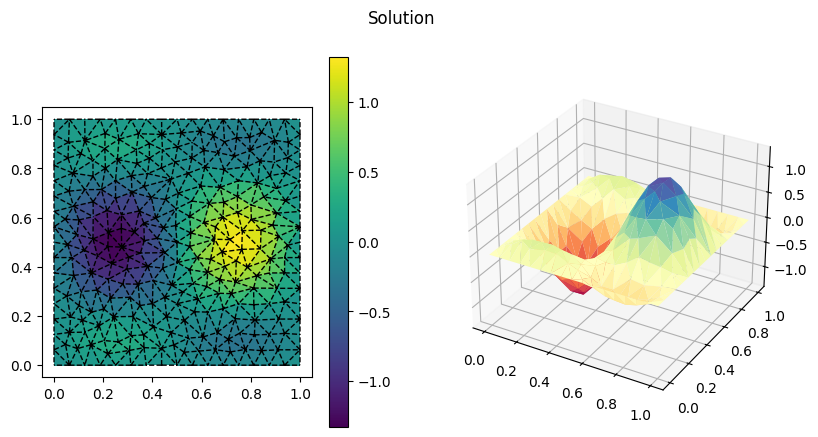

quadratureWeights: [0.00059755 0.00059755 0.00059755 ... 0.00064649 0.00064649 0.00064649]


In [10]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, last_u_k_exact, lib)
print(f"quadratureWeights: {quadratureWeights}")

gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

## 2. PINN

In [13]:
# Just for the first epoch
def generate_data(N_domain=1750, N_boundary=150):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = (torch.rand((1, 2)) * 0.9 + 0.1).expand(N_domain, -1) # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = mu_in[:N_boundary*4, :]
    return x_in, mu_in, xb, mu_b

In [15]:
# For all the other epochs, it samples on the point on the domain in which the loss is higher so that he can learn better
def adaptive_sample(model, N_tot=5000, N_sel=1750, N_boundary=150):
    X = torch.rand(N_tot, 2, device=device)
    M = (torch.rand(N_tot, 2, device=device) * 0.9 + 0.1)

    # Compute the residual
    X.requires_grad_(True)
    R_vals = R(X, M, model).detach().abs().cpu().numpy().flatten()  # .detach() spezza il grafo

    idx = np.argsort(R_vals)[-N_sel:]
    x_int = X.detach()[idx]  
    mu_int = M.detach()[idx]

    # Point on the border
    x0 = torch.rand(N_boundary, 1, device=device)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)
    xb = torch.cat([
        torch.cat([x0, zeros], 1),
        torch.cat([x0, ones], 1),
        torch.cat([zeros, x0], 1),
        torch.cat([ones, x0], 1)
    ], 0)
    mu_b = (torch.rand(1, 2, device=device) * 0.9 + 0.1).expand(xb.shape[0], -1)

    return x_int, mu_int, xb, mu_b

In [16]:
# x: [N, 2], mu: [N, 2]
def R(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # Compute the gradient ∇u (i.e. du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Laplacian = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g = 100 * torch.sin(2 * torch.pi * x0) * torch.cos(2 * torch.pi * x1)

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g

    return residual

#### **Train** computed on Kaggle (see the result in a different folder).

In [60]:
def train_plot(model, epochs=50000, lr=1e-3, lambda_bc=1.0, patience=7500, delta=1e-4, batch_size=None, save_path="./models"):
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_phys_loss = float('inf')
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    using_lbfgs = False

    loss_history_total = []
    loss_history_phys = []
    loss_history_bc = []
    times_per_epoch = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        x_in, mu_in, xb, mu_b = generate_data()

        if epoch != 0:
            x_in, mu_in, xb, mu_b = adaptive_sample(model)

        x_in = x_in.to(device)
        mu_in = mu_in.to(device)
        xb = xb.to(device)
        mu_b = mu_b.to(device)

        try:
            if not using_lbfgs:
                optimizer.zero_grad()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

                loss_total = loss_phys + lambda_bc * loss_bc

                if torch.isnan(loss_total):
                    raise ValueError("NaN detected in Adam loss computation")

                loss_total.backward()
                optimizer.step()

                if loss_phys.item() + delta < best_phys_loss:
                    best_phys_loss = loss_phys.item()
                    best_model_state = model.state_dict()
                    best_model_path = os.path.join(save_path, f"model_best.pth")
                    torch.save(best_model_state, best_model_path)
                    torch.save(best_model_state, "PINNResNet.pth")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                # Interrompe l'allenamento se la total loss è < 1e-4
                if loss_total.item() < 1e-4:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4_PINNResNet.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

                if loss_bc.item() < 1e-1 and loss_phys.item() < 1e-1:
                    print(f"\nSwitching to LBFGS at epoch {epoch}")
                    using_lbfgs = True
                    optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)
                    if best_model_state:
                        model.load_state_dict(best_model_state)

            else:
                def closure():
                    optimizer.zero_grad()
                    loss_phys_cl = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                    u_b_cl = model(xb, mu_b)
                    loss_bc_cl = mse_loss(u_b_cl, torch.zeros_like(u_b_cl))
                    loss_total_cl = loss_phys_cl + lambda_bc * loss_bc_cl

                    if torch.isnan(loss_total_cl):
                        raise ValueError("NaN detected in LBFGS loss computation")

                    loss_total_cl.backward()
                    return loss_total_cl

                optimizer.step(closure)

                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc

                # Interrompe l'allenamento se la total loss è < 1e-4
                if loss_total.item() < 1e-3:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4_PINNResNet.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

        except ValueError as e:
            print(f"\n❌ Training stopped due to error at epoch {epoch}: {str(e)}")
            if best_model_state:
                print("🔄 Reverting to best model state before NaN.")
                model.load_state_dict(best_model_state)
                torch.save(best_model_state, "PINNResNet.pth")
                nan_model_path = os.path.join(save_path, f"model_nan_epoch{epoch}.pth")
                torch.save(model.state_dict(), nan_model_path)
            break

        loss_history_total.append(loss_total.item())
        loss_history_phys.append(loss_phys.item())
        loss_history_bc.append(loss_bc.item())
        times_per_epoch.append(time.time() - start_time)

        if epoch % 500 == 0 or epoch == epochs - 1:
            opt_name = "Adam" if not using_lbfgs else "LBFGS"
            print(f"[{opt_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")

        if not using_lbfgs and epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch} | Best PDE loss: {best_phys_loss:.2e}")
            model.load_state_dict(best_model_state)
            break

    # Salva comunque il modello finale
    final_model_path = os.path.join(save_path, "model_final.pth")
    torch.save(model.state_dict(), final_model_path)

    # Plotta le perdite
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history_total, label='Total Loss')
    plt.plot(loss_history_phys, label='PDE Loss')
    plt.plot(loss_history_bc, label='BC Loss')
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss trends over training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    total_epochs = len(loss_history_total)
    avg_time = sum(times_per_epoch) / total_epochs
    print(f"\n✅ Training complete: {total_epochs} epochs")
    print(f"⏱ Average time per epoch: {avg_time:.4f} seconds")

    return None

#### **Validation**

In [11]:
def validation(model, epochs=10, lambda_bc=1.0):
   
    mse_loss = nn.MSELoss()
    loss_bc = 1
    loss_phys = 1 

    for epoch in range(epochs):   
             
        x_in, mu_in, xb, mu_b = generate_data()
        
        model.eval()

        # Phiycial Loss (residual PDE)
        loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Boundary Loss (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Total Loss 
        loss_total = loss_phys + lambda_bc * loss_bc

        print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

In [62]:
# 1- PINN40
class PINN40(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

PINN40 = PINN40()
PINN40.load_state_dict(torch.load("./PINN40.pth", map_location="cpu"))
validation(PINN40)

Epoch 0 - Loss: 1.576047e-01  [PDE: 2.54e-02, BC: 1.32e-01]
Epoch 1 - Loss: 1.517519e-01  [PDE: 2.41e-02, BC: 1.28e-01]
Epoch 2 - Loss: 1.536939e-01  [PDE: 3.04e-02, BC: 1.23e-01]
Epoch 3 - Loss: 1.540936e-01  [PDE: 2.97e-02, BC: 1.24e-01]
Epoch 4 - Loss: 1.428196e-01  [PDE: 2.44e-02, BC: 1.18e-01]
Epoch 5 - Loss: 1.553091e-01  [PDE: 2.16e-02, BC: 1.34e-01]
Epoch 6 - Loss: 1.528519e-01  [PDE: 2.38e-02, BC: 1.29e-01]
Epoch 7 - Loss: 1.620177e-01  [PDE: 3.56e-02, BC: 1.26e-01]
Epoch 8 - Loss: 1.515946e-01  [PDE: 2.96e-02, BC: 1.22e-01]
Epoch 9 - Loss: 1.661949e-01  [PDE: 3.97e-02, BC: 1.27e-01]


In [63]:
# 2- PINN60 
class PINN60(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

PINN60 = PINN60()
PINN60.load_state_dict(torch.load("./PINN60.pth", map_location="cpu"))
validation(PINN60)

Epoch 0 - Loss: 1.206744e-03  [PDE: 8.94e-04, BC: 3.13e-04]
Epoch 1 - Loss: 1.673180e-03  [PDE: 1.33e-03, BC: 3.46e-04]
Epoch 2 - Loss: 1.349079e-03  [PDE: 9.79e-04, BC: 3.70e-04]
Epoch 3 - Loss: 1.309515e-03  [PDE: 8.64e-04, BC: 4.46e-04]
Epoch 4 - Loss: 1.572498e-03  [PDE: 1.19e-03, BC: 3.80e-04]
Epoch 5 - Loss: 1.562646e-03  [PDE: 1.15e-03, BC: 4.17e-04]
Epoch 6 - Loss: 1.600420e-03  [PDE: 1.28e-03, BC: 3.22e-04]
Epoch 7 - Loss: 1.410131e-03  [PDE: 1.10e-03, BC: 3.12e-04]
Epoch 8 - Loss: 1.544936e-03  [PDE: 1.13e-03, BC: 4.12e-04]
Epoch 9 - Loss: 1.094908e-03  [PDE: 7.17e-04, BC: 3.78e-04]


In [64]:
# 3- PINN80
class PINN80(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

PINN80 = PINN80()
PINN80.load_state_dict(torch.load("./PINN80.pth", map_location="cpu"))
validation(PINN80)

Epoch 0 - Loss: 9.497670e-04  [PDE: 4.72e-04, BC: 4.78e-04]
Epoch 1 - Loss: 1.107276e-03  [PDE: 6.15e-04, BC: 4.92e-04]
Epoch 2 - Loss: 9.878600e-04  [PDE: 5.32e-04, BC: 4.56e-04]
Epoch 3 - Loss: 9.421511e-04  [PDE: 5.01e-04, BC: 4.41e-04]
Epoch 4 - Loss: 1.367924e-03  [PDE: 9.78e-04, BC: 3.90e-04]
Epoch 5 - Loss: 1.794307e-03  [PDE: 1.31e-03, BC: 4.81e-04]
Epoch 6 - Loss: 1.108149e-03  [PDE: 6.53e-04, BC: 4.55e-04]
Epoch 7 - Loss: 1.312886e-03  [PDE: 8.65e-04, BC: 4.48e-04]
Epoch 8 - Loss: 1.126401e-03  [PDE: 5.80e-04, BC: 5.46e-04]
Epoch 9 - Loss: 1.396163e-03  [PDE: 9.31e-04, BC: 4.65e-04]


In [65]:
# 4- PINN128
class PINN128(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

PINN128 = PINN128()
PINN128.load_state_dict(torch.load("./PINN128.pth", map_location="cpu"))
validation(PINN128)

Epoch 0 - Loss: 1.387205e-01  [PDE: 3.43e-02, BC: 1.04e-01]
Epoch 1 - Loss: 1.539031e-01  [PDE: 5.43e-02, BC: 9.96e-02]
Epoch 2 - Loss: 1.458841e-01  [PDE: 4.31e-02, BC: 1.03e-01]
Epoch 3 - Loss: 1.651999e-01  [PDE: 6.26e-02, BC: 1.03e-01]
Epoch 4 - Loss: 1.765520e-01  [PDE: 7.10e-02, BC: 1.06e-01]
Epoch 5 - Loss: 1.686505e-01  [PDE: 6.15e-02, BC: 1.07e-01]
Epoch 6 - Loss: 1.467362e-01  [PDE: 3.16e-02, BC: 1.15e-01]
Epoch 7 - Loss: 1.404402e-01  [PDE: 3.68e-02, BC: 1.04e-01]
Epoch 8 - Loss: 1.429235e-01  [PDE: 3.76e-02, BC: 1.05e-01]
Epoch 9 - Loss: 1.455520e-01  [PDE: 3.78e-02, BC: 1.08e-01]


In [66]:
# 5- PINN_ReLU_60
class PINN_ReLU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_ReLU_60 = PINN_ReLU_60()
PINN_ReLU_60.load_state_dict(torch.load("./PINN_ReLU_60.pth", map_location="cpu"))
validation(PINN_ReLU_60)

Epoch 0 - Loss: 2.598718e+03  [PDE: 2.60e+03, BC: 9.77e-03]
Epoch 1 - Loss: 2.488867e+03  [PDE: 2.49e+03, BC: 9.97e-03]
Epoch 2 - Loss: 2.490510e+03  [PDE: 2.49e+03, BC: 1.07e-02]
Epoch 3 - Loss: 2.534621e+03  [PDE: 2.53e+03, BC: 9.75e-03]
Epoch 4 - Loss: 2.490822e+03  [PDE: 2.49e+03, BC: 1.03e-02]
Epoch 5 - Loss: 2.457104e+03  [PDE: 2.46e+03, BC: 9.63e-03]
Epoch 6 - Loss: 2.524830e+03  [PDE: 2.52e+03, BC: 1.07e-02]
Epoch 7 - Loss: 2.597751e+03  [PDE: 2.60e+03, BC: 1.06e-02]
Epoch 8 - Loss: 2.528797e+03  [PDE: 2.53e+03, BC: 1.00e-02]
Epoch 9 - Loss: 2.653741e+03  [PDE: 2.65e+03, BC: 9.80e-03]


In [67]:
# 6- PINNResNet

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.Tanh(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class PINNResNet(nn.Module):
    def __init__(self, hidden_dim=60, num_blocks=4):
        super().__init__()
        self.input = nn.Linear(4, hidden_dim)
        self.blocks = nn.Sequential(*[ResBlock(hidden_dim) for _ in range(num_blocks)])
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, mu):
        z = torch.cat((x, mu), dim=1)
        z = torch.tanh(self.input(z))
        z = self.blocks(z)
        return self.out(z)

PINNResNet = PINNResNet()
PINNResNet.load_state_dict(torch.load("./PINNResNet.pth", map_location="cpu"))
validation(PINNResNet)

Epoch 0 - Loss: 1.522072e-01  [PDE: 2.64e-02, BC: 1.26e-01]
Epoch 1 - Loss: 1.269207e-01  [PDE: 1.84e-02, BC: 1.09e-01]
Epoch 2 - Loss: 1.426640e-01  [PDE: 2.05e-02, BC: 1.22e-01]
Epoch 3 - Loss: 1.428778e-01  [PDE: 3.04e-02, BC: 1.12e-01]
Epoch 4 - Loss: 1.531209e-01  [PDE: 3.02e-02, BC: 1.23e-01]
Epoch 5 - Loss: 1.406018e-01  [PDE: 2.17e-02, BC: 1.19e-01]
Epoch 6 - Loss: 1.538811e-01  [PDE: 4.07e-02, BC: 1.13e-01]
Epoch 7 - Loss: 1.719359e-01  [PDE: 4.71e-02, BC: 1.25e-01]
Epoch 8 - Loss: 2.029989e-01  [PDE: 8.71e-02, BC: 1.16e-01]
Epoch 9 - Loss: 1.621477e-01  [PDE: 3.48e-02, BC: 1.27e-01]


In [68]:
# 7- PINN_Tanh_Deep
class PINN_Tanh_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(4, 40), nn.Tanh()]
        for _ in range(7):
            layers += [nn.Linear(40, 40), nn.Tanh()]
        layers.append(nn.Linear(40, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_Tanh_Deep = PINN_Tanh_Deep()
PINN_Tanh_Deep.load_state_dict(torch.load("./PINN_Tanh_Deep.pth", map_location="cpu"))
validation(PINN_Tanh_Deep)

Epoch 0 - Loss: 1.119849e-01  [PDE: 4.07e-02, BC: 7.13e-02]
Epoch 1 - Loss: 9.667970e-02  [PDE: 2.90e-02, BC: 6.77e-02]
Epoch 2 - Loss: 1.012906e-01  [PDE: 3.17e-02, BC: 6.96e-02]
Epoch 3 - Loss: 9.812897e-02  [PDE: 2.54e-02, BC: 7.27e-02]
Epoch 4 - Loss: 1.259971e-01  [PDE: 4.54e-02, BC: 8.06e-02]
Epoch 5 - Loss: 9.899538e-02  [PDE: 2.90e-02, BC: 7.00e-02]
Epoch 6 - Loss: 9.836305e-02  [PDE: 2.34e-02, BC: 7.50e-02]
Epoch 7 - Loss: 9.349648e-02  [PDE: 2.12e-02, BC: 7.23e-02]
Epoch 8 - Loss: 1.113904e-01  [PDE: 4.14e-02, BC: 7.00e-02]
Epoch 9 - Loss: 9.800107e-02  [PDE: 2.94e-02, BC: 6.86e-02]


In [69]:
# 8- PINN_SiLU_60 
class PINN_SiLU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_SiLU_60 = PINN_SiLU_60()
PINN_SiLU_60.load_state_dict(torch.load("./PINN_SiLU_60.pth", map_location="cpu"))
validation(PINN_SiLU_60)

Epoch 0 - Loss: 1.484058e-01  [PDE: 1.90e-02, BC: 1.29e-01]
Epoch 1 - Loss: 1.372822e-01  [PDE: 2.24e-02, BC: 1.15e-01]
Epoch 2 - Loss: 1.800504e-01  [PDE: 5.07e-02, BC: 1.29e-01]
Epoch 3 - Loss: 1.393864e-01  [PDE: 2.17e-02, BC: 1.18e-01]
Epoch 4 - Loss: 1.273894e-01  [PDE: 1.48e-02, BC: 1.13e-01]
Epoch 5 - Loss: 1.405852e-01  [PDE: 1.46e-02, BC: 1.26e-01]
Epoch 6 - Loss: 1.456888e-01  [PDE: 1.82e-02, BC: 1.27e-01]
Epoch 7 - Loss: 1.375195e-01  [PDE: 1.70e-02, BC: 1.20e-01]
Epoch 8 - Loss: 1.453228e-01  [PDE: 1.98e-02, BC: 1.25e-01]
Epoch 9 - Loss: 1.463110e-01  [PDE: 1.52e-02, BC: 1.31e-01]


In [70]:
# 9- PINN_Sine_60 

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN_Sine_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_Sine_60 = PINN_Sine_60()
PINN_Sine_60.load_state_dict(torch.load("./PINN_Sine_60.pth", map_location="cpu"))
validation(PINN_Sine_60)

Epoch 0 - Loss: 1.633295e-01  [PDE: 1.48e-02, BC: 1.48e-01]
Epoch 1 - Loss: 1.749518e-01  [PDE: 3.04e-02, BC: 1.45e-01]
Epoch 2 - Loss: 1.719794e-01  [PDE: 2.42e-02, BC: 1.48e-01]
Epoch 3 - Loss: 1.652213e-01  [PDE: 1.53e-02, BC: 1.50e-01]
Epoch 4 - Loss: 1.732249e-01  [PDE: 1.63e-02, BC: 1.57e-01]
Epoch 5 - Loss: 1.753122e-01  [PDE: 3.24e-02, BC: 1.43e-01]
Epoch 6 - Loss: 1.685658e-01  [PDE: 1.64e-02, BC: 1.52e-01]
Epoch 7 - Loss: 1.657772e-01  [PDE: 1.98e-02, BC: 1.46e-01]
Epoch 8 - Loss: 1.915280e-01  [PDE: 4.61e-02, BC: 1.45e-01]
Epoch 9 - Loss: 2.284639e-01  [PDE: 8.60e-02, BC: 1.42e-01]


In [71]:
# 10- PINN_ELU_60 TODO
class PINN_ELU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_ELU_60 = PINN_ELU_60()
PINN_ELU_60.load_state_dict(torch.load("./PINN_ELU_60.pth", map_location="cpu"))
validation(PINN_ELU_60)

Epoch 0 - Loss: 3.433806e+00  [PDE: 3.37e+00, BC: 6.18e-02]
Epoch 1 - Loss: 3.827388e+00  [PDE: 3.76e+00, BC: 6.64e-02]
Epoch 2 - Loss: 3.515227e+00  [PDE: 3.46e+00, BC: 5.98e-02]
Epoch 3 - Loss: 3.325345e+00  [PDE: 3.26e+00, BC: 6.12e-02]
Epoch 4 - Loss: 3.748191e+00  [PDE: 3.68e+00, BC: 6.34e-02]
Epoch 5 - Loss: 3.893595e+00  [PDE: 3.83e+00, BC: 6.71e-02]
Epoch 6 - Loss: 3.824066e+00  [PDE: 3.76e+00, BC: 6.60e-02]
Epoch 7 - Loss: 4.528582e+00  [PDE: 4.46e+00, BC: 7.17e-02]
Epoch 8 - Loss: 3.517395e+00  [PDE: 3.46e+00, BC: 6.17e-02]
Epoch 9 - Loss: 3.603560e+00  [PDE: 3.54e+00, BC: 6.15e-02]


In [72]:
# 11- PINN_LN_60
class PINN_LN_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_LN_60 = PINN_LN_60()
PINN_LN_60.load_state_dict(torch.load("./PINN_LN_60.pth", map_location="cpu"))
validation(PINN_LN_60)

Epoch 0 - Loss: 1.500128e-01  [PDE: 3.87e-02, BC: 1.11e-01]
Epoch 1 - Loss: 1.428333e-01  [PDE: 2.23e-02, BC: 1.20e-01]
Epoch 2 - Loss: 1.473671e-01  [PDE: 2.73e-02, BC: 1.20e-01]
Epoch 3 - Loss: 1.453249e-01  [PDE: 2.13e-02, BC: 1.24e-01]
Epoch 4 - Loss: 1.470847e-01  [PDE: 2.66e-02, BC: 1.21e-01]
Epoch 5 - Loss: 1.530975e-01  [PDE: 2.13e-02, BC: 1.32e-01]
Epoch 6 - Loss: 1.553953e-01  [PDE: 4.21e-02, BC: 1.13e-01]
Epoch 7 - Loss: 1.398478e-01  [PDE: 2.01e-02, BC: 1.20e-01]
Epoch 8 - Loss: 1.366636e-01  [PDE: 1.99e-02, BC: 1.17e-01]
Epoch 9 - Loss: 1.538809e-01  [PDE: 2.79e-02, BC: 1.26e-01]


In [73]:
# 12- PINN_MixAct
class PINN_MixAct(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

PINN_MixAct = PINN_MixAct()
PINN_MixAct.load_state_dict(torch.load("./PINN_MixAct.pth", map_location="cpu"))
validation(PINN_MixAct)

Epoch 0 - Loss: 3.849288e-02  [PDE: 3.51e-02, BC: 3.42e-03]
Epoch 1 - Loss: 5.300363e-02  [PDE: 4.85e-02, BC: 4.47e-03]
Epoch 2 - Loss: 5.642547e-02  [PDE: 5.14e-02, BC: 5.04e-03]
Epoch 3 - Loss: 3.954289e-02  [PDE: 3.60e-02, BC: 3.55e-03]
Epoch 4 - Loss: 4.603537e-02  [PDE: 4.10e-02, BC: 5.06e-03]
Epoch 5 - Loss: 3.707771e-02  [PDE: 3.21e-02, BC: 4.97e-03]
Epoch 6 - Loss: 4.354628e-02  [PDE: 3.83e-02, BC: 5.27e-03]
Epoch 7 - Loss: 4.102327e-02  [PDE: 3.65e-02, BC: 4.56e-03]
Epoch 8 - Loss: 4.260955e-02  [PDE: 3.79e-02, BC: 4.72e-03]
Epoch 9 - Loss: 4.541653e-02  [PDE: 3.99e-02, BC: 5.49e-03]


In [74]:
# 13- DeepResPINN
class DeepResPINN(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.input = nn.Linear(4, width)
        self.hidden1 = nn.Linear(width, width)
        self.hidden2 = nn.Linear(width, width)
        self.hidden3 = nn.Linear(width, width)
        self.output = nn.Linear(width, 1)
        self.act = nn.Tanh()

    def forward(self, x, mu):
        x = torch.cat((x, mu), dim=1)
        h = self.act(self.input(x))
        h1 = self.act(self.hidden1(h))
        h2 = self.act(self.hidden2(h1) + h)  # skip
        h3 = self.act(self.hidden3(h2) + h1)  # another skip
        return self.output(h3)


DeepResPINN = DeepResPINN()
DeepResPINN.load_state_dict(torch.load("./DeepResPINN.pth", map_location="cpu"))
validation(DeepResPINN)

Epoch 0 - Loss: 1.536898e-01  [PDE: 2.31e-02, BC: 1.31e-01]
Epoch 1 - Loss: 1.500117e-01  [PDE: 2.78e-02, BC: 1.22e-01]
Epoch 2 - Loss: 1.593192e-01  [PDE: 3.97e-02, BC: 1.20e-01]
Epoch 3 - Loss: 1.550989e-01  [PDE: 2.29e-02, BC: 1.32e-01]
Epoch 4 - Loss: 1.475993e-01  [PDE: 2.54e-02, BC: 1.22e-01]
Epoch 5 - Loss: 1.473681e-01  [PDE: 2.94e-02, BC: 1.18e-01]
Epoch 6 - Loss: 1.551407e-01  [PDE: 3.81e-02, BC: 1.17e-01]
Epoch 7 - Loss: 1.575389e-01  [PDE: 3.21e-02, BC: 1.25e-01]
Epoch 8 - Loss: 2.171536e-01  [PDE: 8.95e-02, BC: 1.28e-01]
Epoch 9 - Loss: 1.465384e-01  [PDE: 2.47e-02, BC: 1.22e-01]


In [75]:
# 14- FourierPINN
class FourierPINN(nn.Module):
    def __init__(self, width=60, B=10.0):
        super().__init__()
        self.B = nn.Parameter(B * torch.randn(100, 4), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(200, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )

    def forward(self, x, mu):
        x_in = torch.cat((x, mu), dim=1)
        x_proj = 2 * torch.pi * x_in @ self.B.T
        fourier_feats = torch.cat((torch.sin(x_proj), torch.cos(x_proj)), dim=-1)
        return self.net(fourier_feats)



FourierPINN = FourierPINN()
FourierPINN.load_state_dict(torch.load("./FourierPINN.pth", map_location="cpu"))
validation(FourierPINN)

Epoch 0 - Loss: 2.509182e+03  [PDE: 2.51e+03, BC: 4.25e-04]
Epoch 1 - Loss: 2.470749e+03  [PDE: 2.47e+03, BC: 4.21e-04]
Epoch 2 - Loss: 2.459729e+03  [PDE: 2.46e+03, BC: 4.13e-04]
Epoch 3 - Loss: 2.421701e+03  [PDE: 2.42e+03, BC: 4.19e-04]
Epoch 4 - Loss: 2.418686e+03  [PDE: 2.42e+03, BC: 4.20e-04]
Epoch 5 - Loss: 2.644062e+03  [PDE: 2.64e+03, BC: 4.25e-04]
Epoch 6 - Loss: 2.497804e+03  [PDE: 2.50e+03, BC: 4.15e-04]
Epoch 7 - Loss: 2.616029e+03  [PDE: 2.62e+03, BC: 4.19e-04]
Epoch 8 - Loss: 2.372548e+03  [PDE: 2.37e+03, BC: 4.25e-04]
Epoch 9 - Loss: 2.527553e+03  [PDE: 2.53e+03, BC: 4.15e-04]


In [17]:
# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)



PINNHardBC = PINNHardBC()
PINNHardBC.load_state_dict(torch.load("./PINNHardBC.pth", map_location="cpu"))
validation(PINNHardBC)

Epoch 0 - Loss: 2.346236e-03  [PDE: 2.35e-03, BC: 0.00e+00]
Epoch 1 - Loss: 2.477403e-03  [PDE: 2.48e-03, BC: 0.00e+00]
Epoch 2 - Loss: 2.396794e-03  [PDE: 2.40e-03, BC: 0.00e+00]
Epoch 3 - Loss: 2.219877e-03  [PDE: 2.22e-03, BC: 0.00e+00]
Epoch 4 - Loss: 2.292020e-03  [PDE: 2.29e-03, BC: 0.00e+00]
Epoch 5 - Loss: 2.425761e-03  [PDE: 2.43e-03, BC: 0.00e+00]
Epoch 6 - Loss: 2.957006e-03  [PDE: 2.96e-03, BC: 0.00e+00]
Epoch 7 - Loss: 1.879253e-03  [PDE: 1.88e-03, BC: 0.00e+00]
Epoch 8 - Loss: 2.701055e-03  [PDE: 2.70e-03, BC: 0.00e+00]
Epoch 9 - Loss: 2.426233e-03  [PDE: 2.43e-03, BC: 0.00e+00]


#### **Compute the error** on the quadrature points

In [18]:
# Compute quadrature points
quadrature_points = []
file_path = "./Export/SolutionOnPoints_0.inp" # Take the quadrature poing just computed in the HIGH FIDELITY part (before POD)

with open(file_path, "r") as f:
    next(f)  # No point in the header (first line) of the file
    for line in f:
        parts = line.strip().split()
        if len(parts) < 4:
            continue
        try:
            idx = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
        except ValueError:
            # Righe non dati, le salto
            continue

        quadrature_points.append((x, y))
quadrature_points = np.array(quadrature_points)  # shape (N,2)
print(f"quadrature_points.shape: {quadrature_points.shape}")

quadrature_points.shape: (1470, 2)


In [19]:
sample_mu_0 = sample_mu_0.reshape(-1, 1)  # shape: (300, 1)
sample_mu_1 = sample_mu_1.reshape(-1, 1)  # shape: (300, 1)

# Now concatenate column-wise
test_set = np.hstack((sample_mu_0, sample_mu_1))

print(f"test_set.shape: {test_set.shape}")

test_set.shape: (300, 2)


In [20]:
def save_csv_file(name_model):
    coords_tensor = torch.tensor(quadrature_points, dtype=torch.float32)  # (N, 2) # (1470, 2)
    
    all_preds = []
    all_u_x = []
    all_u_y = []
    times_pinn = []
    
    for mu in test_set: # (300,2)
        mu0_val, mu1_val = mu
    
        # Separate mu and x to give to the net 
        x_tensor = coords_tensor  # (N, 2)
        mu_tensor = torch.full((coords_tensor.shape[0], 2), fill_value=0.0, dtype=torch.float32)
        mu_tensor[:, 0] = mu0_val
        mu_tensor[:, 1] = mu1_val
    
        x_tensor.requires_grad_(True)
    
        start_time = time.time()
        u = net(x_tensor, mu_tensor)  # (N, 1)
        time_pinn = time.time() - start_time
        times_pinn.append(time_pinn)
    
        u_pred = u.detach().cpu().numpy().flatten()
        all_preds.append(u_pred)
    
        grads = torch.autograd.grad(
            outputs=u.sum(), inputs=x_tensor, create_graph=False, retain_graph=False
        )[0]  # (N, 2)
        u_x = grads[:, 0].detach().cpu().numpy()
        u_y = grads[:, 1].detach().cpu().numpy()
    
        all_u_x.append(u_x)
        all_u_y.append(u_y)
    
    all_preds = np.array(all_preds).T      # (N_punti, N_mu )
    all_u_x = np.array(all_u_x).T          # (N_punti, N_mu )
    all_u_y = np.array(all_u_y).T          # (N_punti, N_mu )
    
    col_names = [f"mu0_{mu[0]:.3f}_mu1_{mu[1]:.3f}" for mu in test_set]
    
    # Save u
    df_u = pd.DataFrame(all_preds, columns=col_names)
    df_u.to_csv(f"pred_u_{name_model}.csv", index=False)
    
    # Save u_x
    df_ux = pd.DataFrame(all_u_x, columns=col_names)
    df_ux.to_csv(f"pred_u_x_{name_model}.csv", index=False) 
    
    # Save u_y
    df_uy = pd.DataFrame(all_u_y, columns=col_names)
    df_uy.to_csv(f"pred_u_y_{name_model}.csv", index=False)
    
    # Save tempi
    df_times = pd.DataFrame(times_pinn)
    df_times.to_csv(f"time_pinn_{name_model}.csv", index=False)
    
    print("Save: u, u_x, u_y, time")

    return None

In [21]:
def csv(name_model):
    # Carica il CSV delle predizioni pred_u, pred_u_x, pred_u_y, time_pinn
    df = pd.read_csv(f"pred_u_{name_model}.csv")
    
    # Estrai i valori come array NumPy: shape (N_punti, N_mu)
    sol_quad_pinn = df.values.T
    print(np.array(sol_quad_pinn).shape)
    
    print(f"Caricate predizioni: shape = {sol_quad_pinn.shape}")
    
    # Carica il CSV della derivata rispetto a x
    df = pd.read_csv(f"pred_u_x_{name_model}.csv")
    
    # Estrai i valori come array NumPy: shape (N_punti, N_mu)
    der_x_quad_pinn = df.values.T
    print(np.array(der_x_quad_pinn).shape)
    
    # Carica il CSV della derivata rispetto a y
    df = pd.read_csv(f"pred_u_y_{name_model}.csv")
    
    # Estrai i valori come array NumPy: shape (N_punti, N_mu)
    der_y_quad_pinn = df.values.T
    print(np.array(der_y_quad_pinn).shape)
    
    # Carica il CSV dei tempi
    df = pd.read_csv(f"time_pinn_{name_model}.csv")
    return sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn

In [22]:
# Funzione di calcolo errori L2 e H1
def compute_L2_H1_errors_separated(hf_u_set, hf_ux_set, hf_uy_set,
                                   pinn_u_set, pinn_ux_set, pinn_uy_set, weights=None):
    l2_abs_errors = []
    l2_rel_errors = []
    h1_abs_errors = []
    h1_rel_errors = []

    for u_HF, ux_HF, uy_HF, u_pinn, ux_pinn, uy_pinn in zip(
        hf_u_set, hf_ux_set, hf_uy_set, pinn_u_set, pinn_ux_set, pinn_uy_set
    ):
        diff_u = u_pinn - u_HF
        diff_ux = ux_pinn - ux_HF
        diff_uy = uy_pinn - uy_HF

        if weights is not None:
            l2_abs = np.sqrt(np.sum(weights * diff_u**2))
            l2_rel = l2_abs / np.sqrt(np.sum(weights * u_HF**2))

            h1_abs = np.sqrt(np.sum(weights * (diff_u**2 + diff_ux**2 + diff_uy**2)))
            h1_rel = h1_abs / np.sqrt(np.sum(weights * (u_HF**2 + ux_HF**2 + uy_HF**2)))
        else:
            N_q = len(diff_u)
            l2_abs = np.linalg.norm(diff_u) / np.sqrt(N_q)
            l2_rel = l2_abs / (np.linalg.norm(u_HF) / np.sqrt(N_q))

            h1_abs = np.sqrt(
                np.linalg.norm(diff_u)**2 +
                np.linalg.norm(diff_ux)**2 +
                np.linalg.norm(diff_uy)**2
            ) / np.sqrt(N_q)

            h1_rel = h1_abs / (
                np.sqrt(
                    np.linalg.norm(u_HF)**2 +
                    np.linalg.norm(ux_HF)**2 +
                    np.linalg.norm(uy_HF)**2
                ) / np.sqrt(N_q)
            )

        l2_abs_errors.append(l2_abs)
        l2_rel_errors.append(l2_rel)
        h1_abs_errors.append(h1_abs)
        h1_rel_errors.append(h1_rel)

    print(f"L2 absolute error (mean): {np.mean(l2_abs_errors):.4e}")
    print(f"L2 relative error (mean): {np.mean(l2_rel_errors):.4e}")
    print(f"H1 absolute error (mean): {np.mean(h1_abs_errors):.4e}")
    print(f"H1 relative error (mean): {np.mean(h1_rel_errors):.4e}")

    return {
        "L2 Absolute": np.mean(l2_abs_errors),
        "L2 Relative": np.mean(l2_rel_errors),
        "H1 Absolute": np.mean(h1_abs_errors),
        "H1 Relative": np.mean(h1_rel_errors)
    }

In [82]:
# 1- PINN40
class PINN40(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 40), nn.Tanh(),
        nn.Linear(40, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))


# Caricamento del modello
net = PINN40()
net.load_state_dict(torch.load("PINN40.pth", map_location="cpu")) # Load the net
net.eval() # Put the net in eval mode

name_model = "PINN40"

save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

# sol_quad_hf := defined during the HIGH FIDELITY computation
# der_x_quad_hf := defined during the HIGH FIDELITY computation
# der_y_quad_hf := defined during the HIGH FIDELITY computation
# sol_quad_pinn := defined HERE 
# der_x_quad_pinn := defined HERE
# der_y_quad_pinn := defined HERE


errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf, der_x_quad_hf, der_y_quad_hf, sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.9276e-01
L2 relative error (mean): 3.8105e-01
H1 absolute error (mean): 2.1898e+00
H1 relative error (mean): 4.8245e-01


In [83]:
# 2- PINN60
class PINN60(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 60), nn.Tanh(),
        nn.Linear(60, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

net = PINN60()
net.load_state_dict(torch.load("PINN60.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

name_model = "PINN60"
save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 2.4778e-02
L2 relative error (mean): 4.8981e-02
H1 absolute error (mean): 9.9891e-01
H1 relative error (mean): 2.2007e-01


In [84]:
# 3- PINN80
class PINN80(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 80), nn.Tanh(),
        nn.Linear(80, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

# Caricamento del modello
net = PINN80()
net.load_state_dict(torch.load("PINN80.pth", map_location="cpu")) # Load the net

net.eval() # Put the net in eval mode

name_model = "PINN80"

save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 2.5068e-02
L2 relative error (mean): 4.9559e-02
H1 absolute error (mean): 1.0009e+00
H1 relative error (mean): 2.2051e-01


In [85]:
# 4- PINN128
class PINN128(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 128), nn.Tanh(),
        nn.Linear(128, 1)
    )
  def forward(self, x, mu):
    return self.net(torch.cat((x, mu), dim=1))

net = PINN128()
net.load_state_dict(torch.load("PINN128.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "PINN128"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.7556e-01
L2 relative error (mean): 3.4705e-01
H1 absolute error (mean): 2.0277e+00
H1 relative error (mean): 4.4672e-01


In [86]:
# 5- PINN_ReLU_60 
class PINN_ReLU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_ReLU_60()
net.load_state_dict(torch.load("PINN_ReLU_60.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

name_model = "PINN_ReLU_60.pth"
save_csv_file(name_model)
sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 5.1681e-01
L2 relative error (mean): 1.0216e+00
H1 absolute error (mean): 4.5390e+00
H1 relative error (mean): 1.0000e+00


In [87]:
# 6- PINNResNet

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.Tanh(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class PINNResNet(nn.Module):
    def __init__(self, hidden_dim=60, num_blocks=4):
        super().__init__()
        self.input = nn.Linear(4, hidden_dim)
        self.blocks = nn.Sequential(*[ResBlock(hidden_dim) for _ in range(num_blocks)])
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, mu):
        z = torch.cat((x, mu), dim=1)
        z = torch.tanh(self.input(z))
        z = self.blocks(z)
        return self.out(z)

net = PINNResNet()
net.load_state_dict(torch.load("PINNResNet.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

name_model = "PINNResNet.pth"

save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.8131e-01
L2 relative error (mean): 3.5844e-01
H1 absolute error (mean): 2.1888e+00
H1 relative error (mean): 4.8224e-01


In [88]:
# 7- PINN_Tanh_Deep
class PINN_Tanh_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(4, 40), nn.Tanh()]
        for _ in range(7):
            layers += [nn.Linear(40, 40), nn.Tanh()]
        layers.append(nn.Linear(40, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_Tanh_Deep()
net.load_state_dict(torch.load("PINN_Tanh_Deep.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

name_model = "PINN_Tanh_Deep"

save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.5873e-01
L2 relative error (mean): 3.1378e-01
H1 absolute error (mean): 1.7096e+00
H1 relative error (mean): 3.7665e-01


In [89]:
# 8- PINN_SiLU_60
class PINN_SiLU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 60), nn.SiLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_SiLU_60()
net.load_state_dict(torch.load("PINN_SiLU_60.pth", map_location="cpu")) # CHANGE HERE THE NAME

name_model = "PINN_SiLU_60.pth"
net.eval() # Put the net in eval mode

save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.7823e-01
L2 relative error (mean): 3.5232e-01
H1 absolute error (mean): 2.1978e+00
H1 relative error (mean): 4.8420e-01


In [90]:
# 9- PINN_Sine_60 

class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN_Sine_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 60), Sine(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_Sine_60()
net.load_state_dict(torch.load("PINN_Sine_60.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

name_model = "PINN_Sine_60"
save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.8981e-01
L2 relative error (mean): 3.7523e-01
H1 absolute error (mean): 2.3727e+00
H1 relative error (mean): 5.2273e-01


In [91]:
# 10- PINN_ELU_60
class PINN_ELU_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 60), nn.ELU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_ELU_60()
net.load_state_dict(torch.load("PINN_ELU_60.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

name_model = "PINN_ELU_60"
save_csv_file(name_model)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(name_model)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.6047e-01
L2 relative error (mean): 3.1729e-01
H1 absolute error (mean): 1.5914e+00
H1 relative error (mean): 3.5060e-01


In [92]:
# 11- PINN_LN_60
class PINN_LN_60(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 60), nn.LayerNorm(60), nn.Tanh(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_LN_60()
net.load_state_dict(torch.load("PINN_LN_60.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "PINN_LN_60"
save_csv_file(model_name)
sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.8070e-01
L2 relative error (mean): 3.5723e-01
H1 absolute error (mean): 2.1769e+00
H1 relative error (mean): 4.7960e-01


In [93]:
# 12- PINN_MixAct
class PINN_MixAct(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        return self.net(torch.cat((x, mu), dim=1))

net = PINN_MixAct()
net.load_state_dict(torch.load("PINN_MixAct.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "PINN_MixAct"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 6.2440e-01
L2 relative error (mean): 1.2343e+00
H1 absolute error (mean): 4.5287e+00
H1 relative error (mean): 9.9775e-01


In [94]:
# 13- DeepResPINN
class DeepResPINN(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.input = nn.Linear(4, width)
        self.hidden1 = nn.Linear(width, width)
        self.hidden2 = nn.Linear(width, width)
        self.hidden3 = nn.Linear(width, width)
        self.output = nn.Linear(width, 1)
        self.act = nn.Tanh()

    def forward(self, x, mu):
        x = torch.cat((x, mu), dim=1)
        h = self.act(self.input(x))
        h1 = self.act(self.hidden1(h))
        h2 = self.act(self.hidden2(h1) + h)  # skip
        h3 = self.act(self.hidden3(h2) + h1)  # another skip
        return self.output(h3)


net = DeepResPINN()
net.load_state_dict(torch.load("DeepResPINN.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "DeepResPINN"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 1.8972e-01
L2 relative error (mean): 3.7505e-01
H1 absolute error (mean): 2.1414e+00
H1 relative error (mean): 4.7178e-01


In [95]:
# 14- FourierPINN
class FourierPINN(nn.Module):
    def __init__(self, width=60, B=10.0):
        super().__init__()
        self.B = nn.Parameter(B * torch.randn(100, 4), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(200, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )

    def forward(self, x, mu):
        x_in = torch.cat((x, mu), dim=1)
        x_proj = 2 * torch.pi * x_in @ self.B.T
        fourier_feats = torch.cat((torch.sin(x_proj), torch.cos(x_proj)), dim=-1)
        return self.net(fourier_feats)


net = FourierPINN()
net.load_state_dict(torch.load("FourierPINN.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "FourierPINN"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 5.0618e-01
L2 relative error (mean): 1.0006e+00
H1 absolute error (mean): 4.5392e+00
H1 relative error (mean): 1.0000e+00


In [23]:
# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)


net = PINNHardBC()
net.load_state_dict(torch.load("PINNHardBC.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "PINNHardBC"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

Save: u, u_x, u_y, time
(300, 1470)
Caricate predizioni: shape = (300, 1470)
(300, 1470)
(300, 1470)
L2 absolute error (mean): 2.1194e-02
L2 relative error (mean): 4.1897e-02
H1 absolute error (mean): 9.8966e-01
H1 relative error (mean): 2.1803e-01
